**IMPORT NECESSARY MODULE/PACKAGE**

In [107]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
plt.style.use('fivethirtyeight')


In [108]:
df_stock= pd.read_csv('../Data/MSFT_historical_data_yfinance.csv')
target= 'Close'
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.index= df_stock['Date']
print(df_stock.dtypes)

Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Date      datetime64[ns]
dtype: object


In [109]:
df_stock.head()


,Open,High,Low,Close,Volume,Date
Date,,,,,,
2013-12-13,31.509763,31.535026,30.836118,30.895061,40066100,2013-12-13
2013-12-16,30.928732,31.156088,30.768743,31.063461,31734200,2013-12-16
2013-12-17,31.105562,31.248713,30.591910,30.751900,45687700,2013-12-17
2013-12-18,30.617180,30.819271,29.918271,30.802433,63192100,2013-12-18
2013-12-19,30.743483,30.777166,30.381401,30.524549,34160100,2013-12-19


In [110]:
df_stock.tail()

,Open,High,Low,Close,Volume,Date
Date,,,,,,
2023-12-07,368.230011,371.450012,366.320007,370.950012,23118900,2023-12-07
2023-12-08,369.200012,374.459991,368.230011,374.230011,20144800,2023-12-08
2023-12-11,368.480011,371.600006,366.100006,371.299988,27708800,2023-12-11
2023-12-12,370.850006,374.420013,370.459991,374.380005,24793900,2023-12-12
2023-12-13,376.019989,377.636108,375.079987,375.880188,4696314,2023-12-13


**VISUALIZING DATASET**

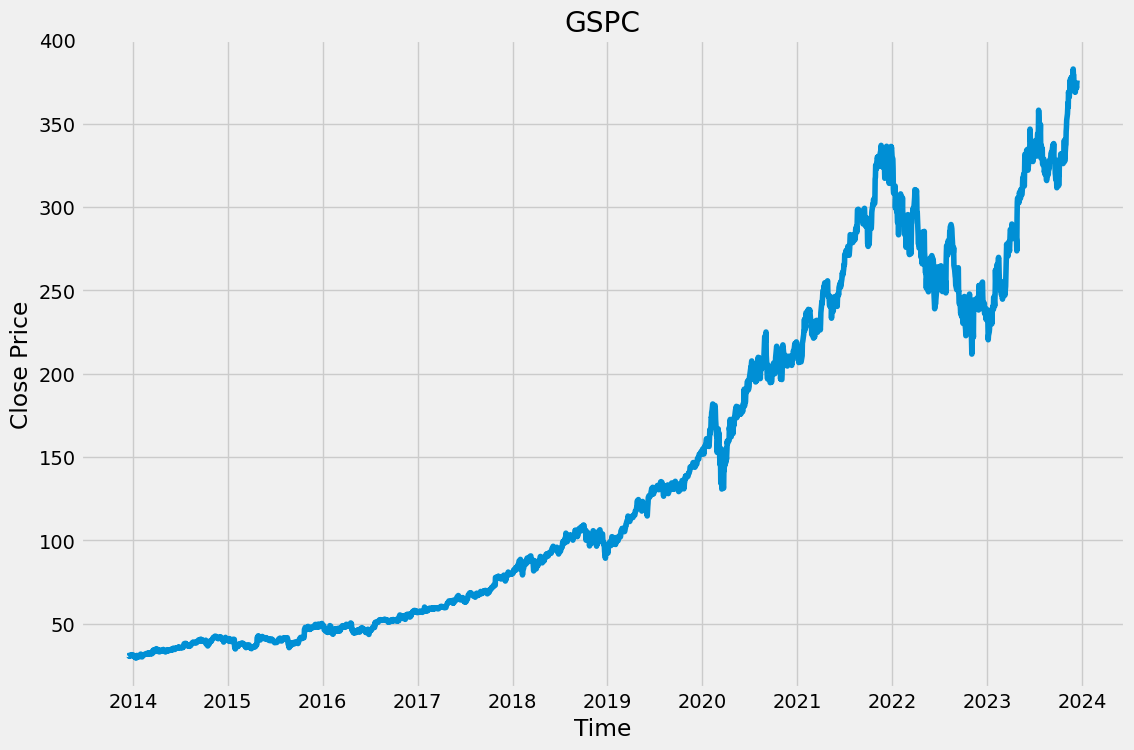

In [111]:
plt.figure(figsize=(12,8))
plt.title('GSPC')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.plot(df_stock[target])
plt.show()


**DIVIDE DATASET INTO TRAIN SET, TEST SET**

In [112]:
x = df_stock.drop([target, 'Date'], axis=1)
y=df_stock[target]
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2, random_state= 100,shuffle=False)

In [113]:
x_test.shape
y_test.shape

(504,)

**USING GRIDSEARCHCV TO FINE THE BEST PARAMETER FOR THE SVR MODEL AND USING IT TO TRAIN**

In [114]:
param_grid = {
    'reg__C': [0.1, 1, 10],
    'reg__kernel': ['linear', 'rbf', 'poly'],
    'reg__epsilon': [0.1, 0.2, 0.5]
}

In [115]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', SVR())
])

In [116]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg', SVR())]),
             param_grid={'reg__C': [0.1, 1, 10],
                         'reg__epsilon': [0.1, 0.2, 0.5],
                         'reg__kernel': ['linear', 'rbf', 'poly']},
             scoring='neg_mean_squared_error')

In [117]:
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Best Parameters: {'reg__C': 10, 'reg__epsilon': 0.1, 'reg__kernel': 'linear'}


In [118]:
best_model = grid_search.best_estimator_
y_predict= best_model.predict(x_test)

**EVALUATION THE MODEL**

In [119]:
mae_best = mean_absolute_error(y_test, y_predict)
mse_best = mean_squared_error(y_test, y_predict)
r2_best = r2_score(y_test, y_predict)

print(f'Mean Absolute Error (Best Model): {mae_best}')
print(f'Mean Squared Error (Best Model): {mse_best}')
print(f'R-squared (Best Model): {r2_best}')


Mean Absolute Error (Best Model): 1.7490959583215553
Mean Squared Error (Best Model): 4.8931538803912
R-squared (Best Model): 0.9969547222539334


In [120]:
comparison_df = pd.DataFrame({'Date': x_test.index,
                               'Actual': y_test.values,
                               'Predicted': y_predict})
comparison_df = comparison_df.sort_values(by='Date')

comparison_df.set_index('Date', inplace=True)




In [121]:
comparison_df

,Actual,Predicted
Date,,
2021-12-13,333.294037,335.842156
2021-12-14,322.432983,322.916035
2021-12-15,328.629425,324.460327
2021-12-16,319.054901,322.976134
2021-12-17,317.974670,315.651474
...,...,...
2023-12-07,370.950012,369.464449
2023-12-08,374.230011,372.237626
2023-12-11,371.299988,369.357369


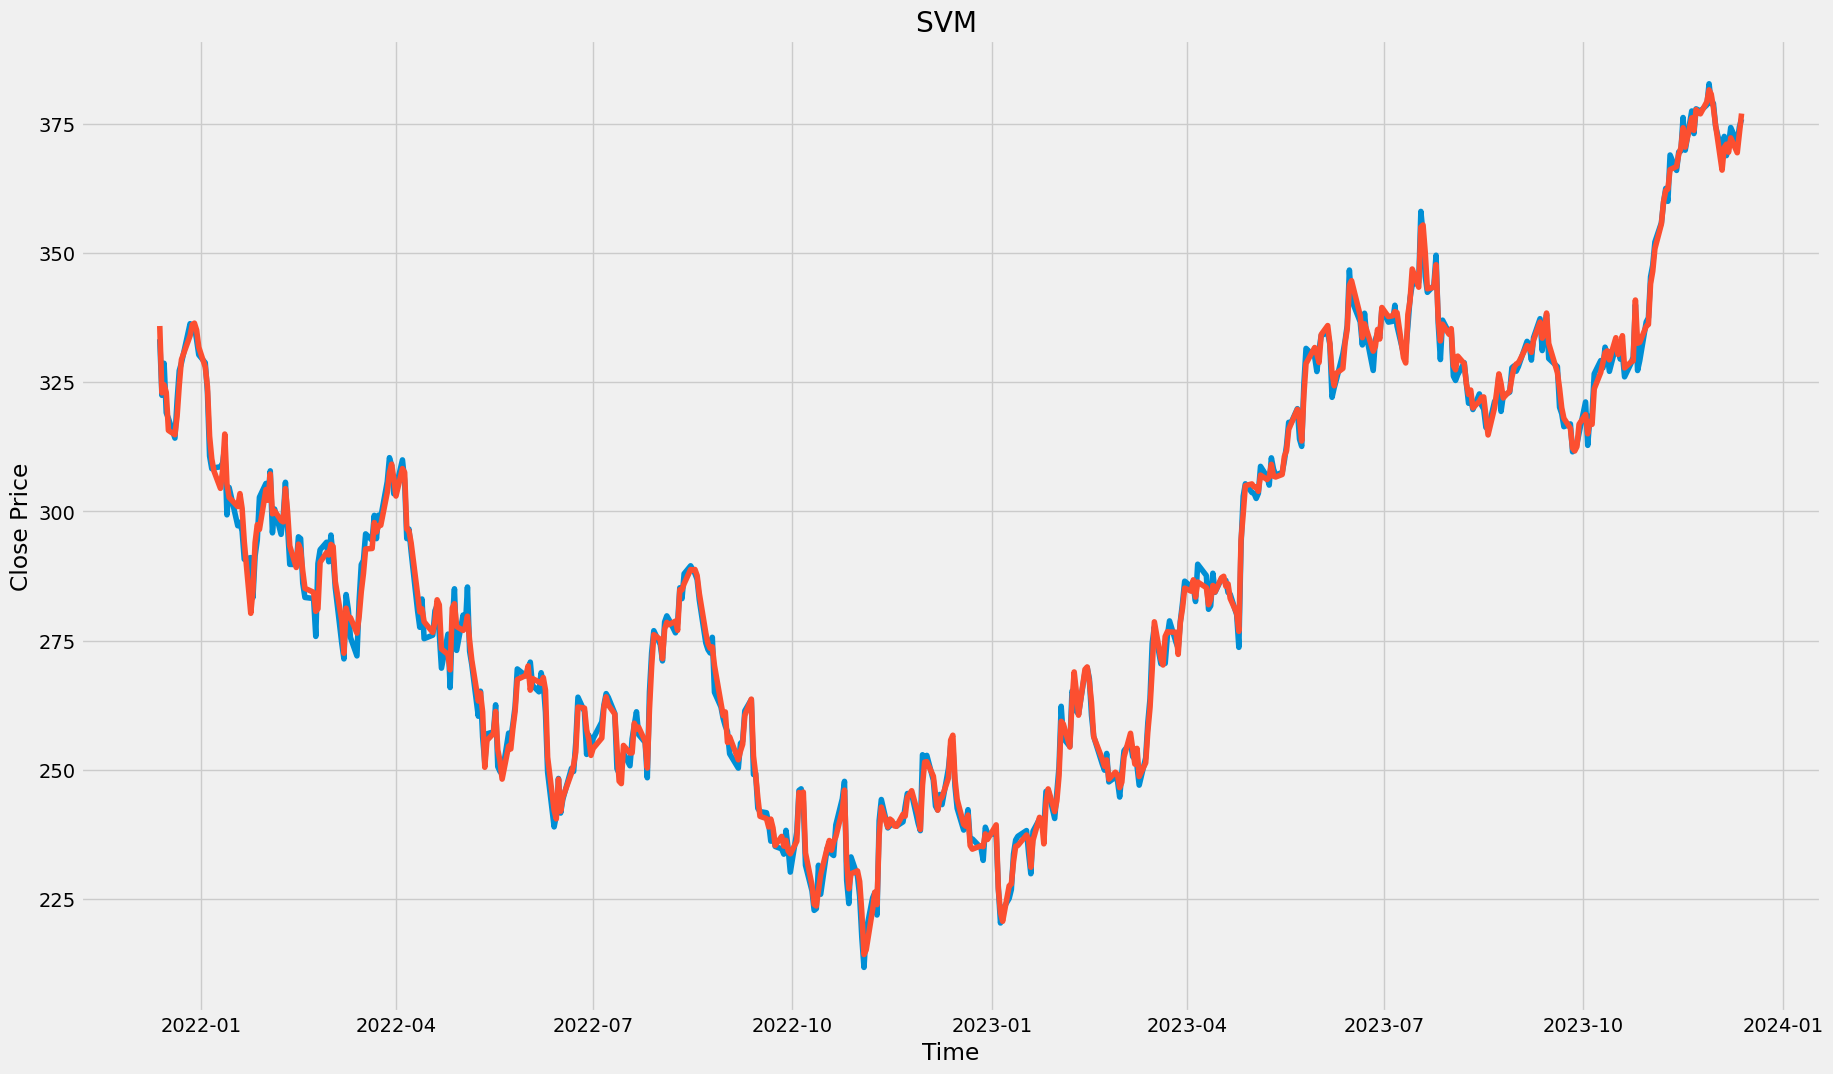

In [122]:
plt.figure(figsize=(20,12))
plt.title('SVM ')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.plot(comparison_df[['Actual', 'Predicted']])
plt.show()